---
### Setup Instructions

Before starting with the notebooks, it is crucial to set up a dedicated Conda environment to ensure that all dependencies do not conflict with the general system installations and other projects.

You can create a new Conda environment by running the following command in your terminal. Replace `your_env_name` with a name you prefer for your environment:

```bash
conda create -n your_env_name
conda activate your_env_name
pip install -r requirements.txt
```
---

## 1. Dataset Preparation

This cell utilizes a custom `PrepareDataset` class from the `utils.prepare_dataset` module to process medical images for machine learning applications. It's designed to handle single-channel images, particularly suitable for fluorescent microscopy images after the relevant fluorescent channel has been extracted.

### Important Usage Notes

- **Single-channel Requirement:** Ensure that the `image_paths` provided are for single-channel images. This is particularly crucial when dealing with fluorescent images; the specific fluorescent channel must be extracted prior to input.
- **One-time Execution:** This script is intended to be run once per dataset to avoid duplicating the processing steps. Re-execution will reprocess and overwrite the existing output.

### Functionality

The script performs the following main tasks:

- **Reads TIFF Images:** It loads TIFF images from specified paths. (If you have single image, be sure that input has array format, ['image1'] etc.)
- **Patch Division:** Divides images into smaller patches of size specific pixels (256,256 etc.), which are more manageable for deep learning models.
- **Mask Application:** Applies corresponding segmentation masks to each image patch.
- **Training/Validation Split:** Splits the image patches into training and validation datasets based on a specified ratio (75% training, 25% validation in this case).
- **Output Format:** Saves the processed patches in PNG format to the designated output directory.

### Parameters

- `image_paths`: Paths to the input images. Example: `['/path/to/image1.tif']`
- `mask_paths`: Paths to the segmentation masks corresponding to the images. Example: `['/path/to/mask1.tif']`
- `output_dir`: The directory where the processed patches will be saved.
- `train_ratio`: The proportion of patches to include in the training set (0.75 or 75%).
- `patch_size`: The size of each image patch (256 pixels square).
- `label_threshold`: The minimum proportion of a mask that must be present in a patch for it to be included in the dataset (0.05 or 5%).
- `overlap_ratio`: The overlap between consecutive patches as a fraction of the patch size (0.5 or 50%).

Warning: Ensure not to rerun this cell unintentionally to prevent data duplication.

In [ ]:
from utils.prepare_dataset import PrepareDataset

PrepareDataset(
    image_paths=['original_content/tile1_PhaseContrast_shifted.tif'],
    mask_paths=['original_content/tile_1_ground_truth.tif'],
    output_dir='dataset',
    train_ratio=0.75,
    patch_size=256,
    label_threshold=0.05,
    overlap_ratio=0.5
).divide_into_patches()

## 2. Data Augmentation for Image Dataset

This cell applies a series of data augmentation techniques to the images and corresponding masks in the training dataset to enhance model generalization. The augmented data are saved directly into specified directories for further use in training deep learning models.

### Augmentation Pipeline

The cell employs the following transformations using the `albumentations` library, which provides a wide range of fast image augmentation techniques:

- **Horizontal Flip**: Mirrors the image horizontally.
- **Vertical Flip**: Mirrors the image vertically.
- **Random Brightness Contrast**: Randomly adjusts brightness and contrast.
- **Elastic Transform**: Applies elastic transformations.
- **Random Rotate 90**: Rotates the images by 90 degrees randomly.
- **Coarse Dropout**: Randomly masks out rectangular regions within the image.
- **Random Gamma**: Adjusts the gamma of the image.
- **Shift Scale Rotate**: Randomly applies affine transforms: translation, scaling, and rotation.
- **Blur**: Applies a blur filter to the images.
- **Optical Distortion**: Distorts the image in a way that mimics optical distortion.

These transformations are composed into a single pipeline which is applied to each image and its corresponding mask.

### Target Directories

- `mask_path`: Path to the directory containing the mask files.
  - Example: `"dataset/train/masks"`
- `images_path`: Path to the directory containing the image files.
  - Example: `"dataset/train/images"`

In [ ]:
from utils.data_augmentation import save_dataset
import albumentations as A

transforms = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomBrightnessContrast(),
    A.ElasticTransform(),
    A.RandomRotate90(),
    A.CoarseDropout(),
    A.RandomGamma(),
    A.ShiftScaleRotate(),
    A.Blur(),
    A.OpticalDistortion(),
])

mask_path = "dataset/train/masks"
images_path = "dataset/train/images"

'''
The `save_dataset` function from the `utils.data_augmentation` module is used to apply the defined transformations 
to each image and mask pair, repeating the process a specified number of times to enhance the dataset size:
'''

save_dataset(
    image_dir = images_path,
    mask_dir = mask_path,
    num_rep=2, # number of augmentations you need
    transforms=transforms)

## 3. Data Loading for  Training

This cell initializes the datasets for training and validation using the `AstrocyteDataset` class from the `utils.datasets` module. It also sets up data loaders which enable efficient batching, shuffling, and parallel loading of the data during the training process of a neural network.

### Dataset Initialization

Two separate instances of the `AstrocyteDataset` are created for both training and validation datasets:

- **Training Dataset**: This dataset includes images and masks from the specified training directories. It will be used to train the neural network.
- **Validation Dataset**: This dataset includes images and masks from the specified validation directories. It is crucial for evaluating the model's performance and preventing overfitting.


In [1]:
from utils.datasets import AstrocyteDataset
from torch.utils.data import DataLoader

batch_size = 12

train_dataset = AstrocyteDataset(
    image_dir='dataset/train/images',
    mask_dir='dataset/train/masks'
)

val_dataset = AstrocyteDataset(
    image_dir='dataset/val/images',
    mask_dir='dataset/val/masks'
)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

## 4. Combined Dice and Focal Loss Function

The `CombinedDiceFocalLoss` class is a custom PyTorch loss function that combines Dice Loss and Focal Loss into a single loss function. This combined approach is particularly useful for handling class imbalance in image segmentation tasks by simultaneously optimizing the model for both region overlap (using Dice Loss) and focus on hard-to-classify pixels (using Focal Loss).

### Overview

- **Dice Loss**: This loss function is used for measuring the overlap between two samples and is especially useful for segmentation tasks. It computes the Dice coefficient between the predicted and true masks and subtracts this value from 1 to maximize the overlap during training.
- **Focal Loss**: Focal Loss focuses training on hard-to-classify examples and down-weights the well-classified examples, thereby focusing more on challenging areas of the image.
- **Weighting Scheme**: Both losses are combined in a weighted scheme where each loss's contribution to the total loss can be adjusted.

Warning: Be aware that your model output are logits or not, than consider to use `from_logits` of `smp.losses.DiceLoss`.

In [ ]:
import torch
import segmentation_models_pytorch as smp

class CombinedDiceFocalLoss(torch.nn.Module):
    def __init__(self, dice_weight=0.5, focal_weight=0.5):
        super(CombinedDiceFocalLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss(mode = 'binary')
        self.focal_loss = smp.losses.FocalLoss(mode = 'binary')
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight

    def forward(self, y_pred, y_true):
        dice = self.dice_loss(y_pred, y_true)
        focal = self.focal_loss(y_pred, y_true)

        return self.dice_weight * dice + self.focal_weight * focal

## 5. Model Configuration and Training Setup

This section details the setup for training a U-Net model using PyTorch and the segmentation_models_pytorch library, including device setup, model initialization, optimizer, and loss function configurations.

### Network Parameters

- `encoder_name`: Encoder block of the UNet. Example: `inceptionv4` (Check available encoders: [Available Encoders for SMP](https://smp.readthedocs.io/en/latest/encoders.html))
- `encoder_weights`: Pretrained weights. Example: `imagenet`
- `in_channels`: Model input channels (1 for gray-scale images, 3 for RGB, etc.)
- `classes` : Model output channels (number of classes in your dataset)
- `decoder_use_batchnorm`: True if batch normalization, else False
- `activation`: Segmentation layer (final layer) of the model, remove if you don't want to achieve specific activation function output

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 5

model = smp.Unet(
    encoder_name="vgg16",  # use `inceptionv4` encoder
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder
    in_channels=1,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset),
    decoder_use_batchnorm = True,
    activation = 'sigmoid'
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4) # weight_decay=1e-4 for L2 regularization
criterion = CombinedDiceFocalLoss()

## 6. Training Process Execution

This section describes how to use the `training` function from the `utils.train` module to train the neural network model defined earlier. The function encapsulates the entire training and validation process over a specified number of epochs.

### Function Overview

The `training` function takes several parameters related to the model, its environment, and the training process, executing the training loop internally and returning lists of losses and accuracies for both training and validation phases.

### Parameters

- `model`: The neural network model to be trained.
- `loss_fn`: The loss function used to evaluate the model's performance.
- `optimizer`: The optimization algorithm used to update the model's weights.
- `train_loader`: DataLoader for the training dataset, providing batches of data.
- `val_loader`: DataLoader for the validation dataset, used to evaluate model performance and generalizeability.
- `epochs`: The total number of training cycles to perform.
- `device`: The device (CPU or GPU) on which the model should be trained.

100%|██████████| 157/157 [03:32<00:00,  1.35s/it]


Epoch 1 average loss: 0.389, average accuracy: 0.595 average val loss: 0.389, average val accuracy: 0.677


100%|██████████| 157/157 [03:30<00:00,  1.34s/it]


Epoch 2 average loss: 0.371, average accuracy: 0.650 average val loss: 0.381, average val accuracy: 0.673


100%|██████████| 157/157 [03:30<00:00,  1.34s/it]


Epoch 3 average loss: 0.366, average accuracy: 0.657 average val loss: 0.379, average val accuracy: 0.677


100%|██████████| 157/157 [03:31<00:00,  1.35s/it]


Epoch 4 average loss: 0.362, average accuracy: 0.666 average val loss: 0.375, average val accuracy: 0.711


100%|██████████| 157/157 [03:32<00:00,  1.35s/it]


Epoch 5 average loss: 0.359, average accuracy: 0.676 average val loss: 0.371, average val accuracy: 0.723


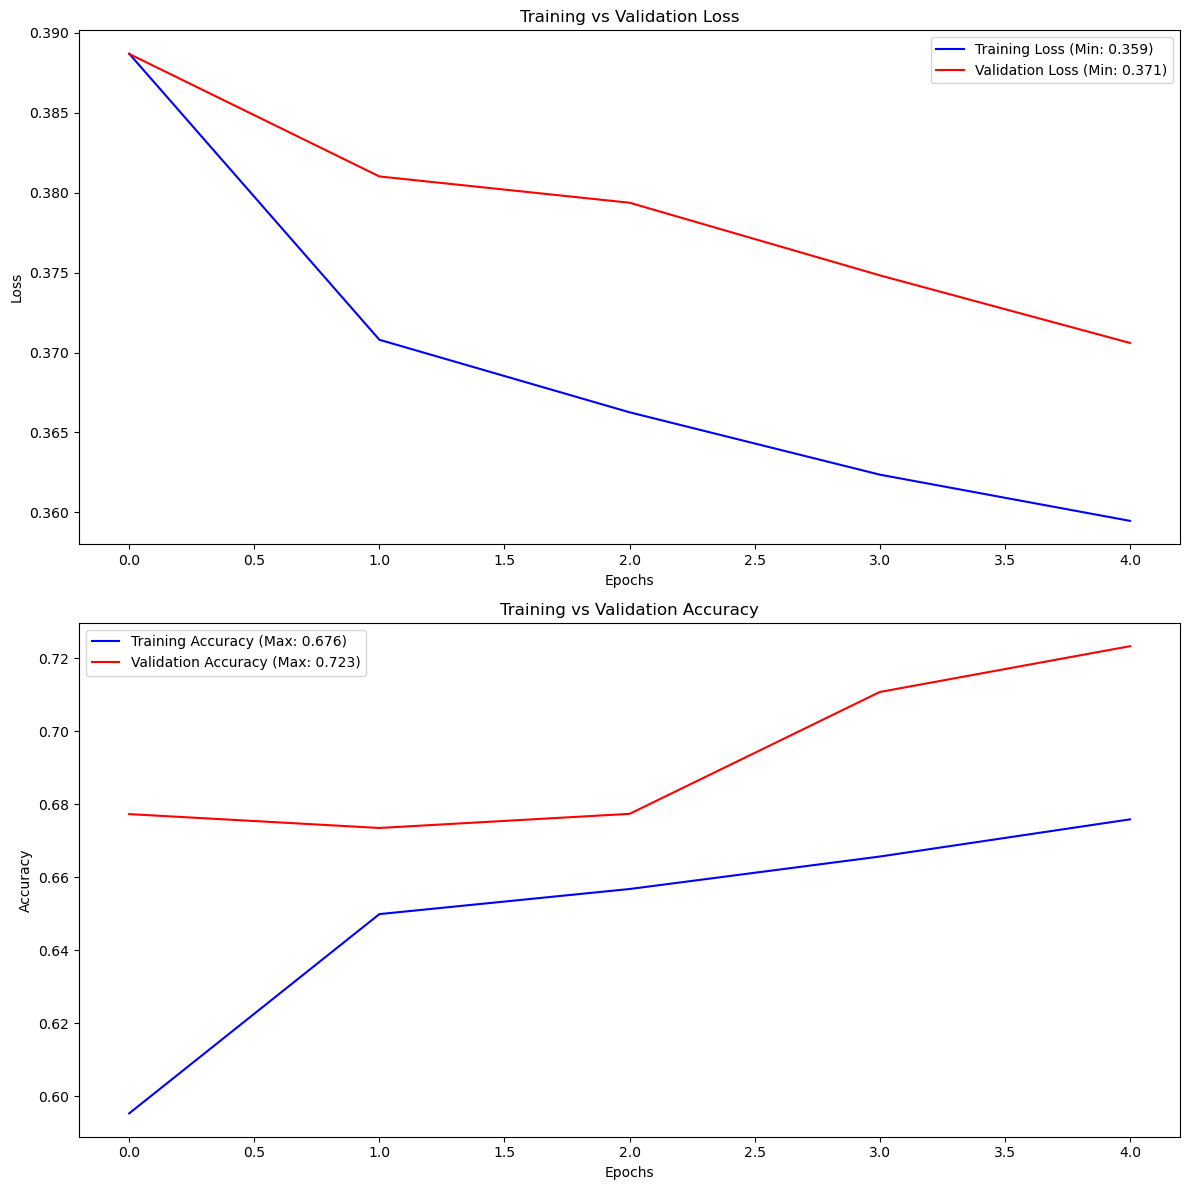

In [4]:
from utils.train import training

train_loss_list, train_acc_list, val_loss_list, val_acc_list = training(
    model = model,
    loss_fn=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    device=device
)

## 7. Image Segmentation and Reconstruction

The `SingleTileProcessor` class in the `utils.image_generator` module is designed for processing single tiles of microscopy or similar images using a deep learning model. The class handles the segmentation of large images by dividing them into smaller patches, processing each patch through a trained model, and then reconstructing the original image dimensions with predicted segmentation results.

### Functionality Overview

The `SingleTileProcessor` executes the following steps:

1. **Image Patch Division**: The original image is divided into smaller patches of a predefined size. Each patch is then processed independently.
2. **Model Prediction**: Each patch is fed into the trained neural network model to predict the segmentation.
3. **Image Reconstruction**: After processing, the patches are reassembled into the original image size, forming a complete segmented image.

### Initialization Parameters

- **size1** and **size2**: Dimensions of the input image. These should match the dimensions of the ground truth for accurate reconstruction.
- **patch_size**: The size of each image patch. This should be the same as the patch size used during model training.
- **input_path**: Path to the original image file.
- **output_path**: Directory where the segmented output image will be saved.
- **model**: The trained neural network model used for segment prediction.
- **device**: The computational device (`cuda` or `cpu`) on which the model will execute.
- **loss_fn**: The name of the loss function used during model training, used here for naming conventions in outputs.
- **model_name**: The name of the model, used for output naming conventions.

In [5]:
from utils.image_generator import SingleTileProcessor, ImageAnalysis

input_path = "original_content/tile1_PhaseContrast_shifted.tif"
output_path = "segmentation_results"

processor = SingleTileProcessor(
    size1=4608, # x
    size2=4608, # y
    patch_size=256, # patch size of the training dataset, (it should match while reconstructing)
    input_path=input_path, # original image
    output_path=output_path, # output path of the constructed image
    model=model, # model with weights
    device=device, # cuda
    loss_fn='CombinedDiceFocalLoss', # just for the naming
    model_name='VGG16' # just for the naming
)

processor.execute()

16-bit image detected


100%|██████████| 35/35 [01:07<00:00,  1.93s/it]


## 8. Image Segmentation Analysis

The `ImageAnalysis` class provides a structured way to evaluate the performance of a segmentation model by comparing the predicted segmentation results against the ground truth. This analysis helps in quantifying the model's accuracy and other statistical measures, which are crucial for assessing model effectiveness.

### Functionality Overview

`ImageAnalysis` takes the paths to the ground truth and the segmentation results, performs comparisons, and calculates several key metrics:

- **True Positives (TP)**: Correctly predicted positive values.
- **True Negatives (TN)**: Correctly predicted negative values.
- **False Positives (FP)**: Incorrectly predicted as positive.
- **False Negatives (FN)**: Incorrectly predicted as negative.
- **Accuracy**: The proportion of true results (both true positives and true negatives) among the total number of cases examined.
- **F1 Score**: The harmonic mean of precision and recall.
- **Recall**: The ratio of correctly predicted positive observations to the all observations in actual class.
- **Precision**: The ratio of correctly predicted positive observations to the total predicted positives.

These metrics provide a comprehensive overview of model performance, especially in terms of its ability to correctly identify and segment relevant features in images.

### Initialization Parameters

- **gt_path**: The file path to the ground truth image.
- **seg_path**: The file path to the segmented image produced by the model.
- **plot_conf_matrix**: A boolean that specifies whether to plot a confusion matrix of the segmentation results.

In [6]:
gt_path = 'original_content/tile_1_ground_truth.tif'
seg_path = 'segmentation_results/tile1_PhaseContrast_shifted_ov128_CombinedDiceFocalLoss_VGG16.tif'

analysis = ImageAnalysis(
    gt_path=gt_path, # path to ground truth
    seg_path=seg_path, # path to segmentation result 
    plot_conf_matrix=True)

metrics = analysis.analyze()

In [9]:
import pandas as pd

df = pd.DataFrame.from_dict([metrics])  # The [metrics] conversion creates a list of one dictionary, ideal for a single row DataFrame
df

,TP,TN,FP,FN,Accuracy,F1 Score,Recall,Precision
0,25.14%,0.00%,74.86%,0.00%,25.14%,40.18%,100.00%,25.14%


---

## Authorship

This notebook was created by **Fahri Burak Nebioglu**, **Muhammed Pesen**.
### Contact Information:
- [fahri.nebioglu@std.medipol.edu.tr](mailto:fahri.nebioglu@std.medipol.edu.tr) 

- [muhammed.pesen@std.medipol.edu.tr](mailto:muhammed.pesen@std.medipol.edu.tr)


---

**Note**: This notebook is intended for educational and research purposes. Please feel free to reach out with suggestions or for collaborations.

---
---